# 4. Outras análises

Nesta seção final vamos fazer mais duas análises sobre os dados levantados.

## 4.1. Preparação

### 4.1.1. Imports

In [1]:

import os

from pathlib import Path
from collections import defaultdict
import itertools
import duckdb
import numpy as np
import pandas as pd
import igraph as ig
import seaborn as sns
from tramita.gold import (
    get_gini,
    Event,
)
import matplotlib.pyplot as plt
from dotenv import load_dotenv

load_dotenv()
pd.set_option('display.max_rows', 20)

sns.set_style('darkgrid')

PROJECT_DIR = Path("~/tramita").expanduser()
DB_PATH = PROJECT_DIR / os.getenv("SILVER_DUCKDB_PATH", "")
OUT_DIR = PROJECT_DIR / "gold" / "outputs"
OUT_DIR.mkdir(exist_ok=True)
ACCESS_DIR = PROJECT_DIR / "gold" / "accessory_data"
ACCESS_DIR.mkdir(exist_ok=True)

NODES_PATH_PARQUET = OUT_DIR / "nodes.parquet"
EDGES_PATH_PARQUET = OUT_DIR / "edges.parquet"
NODES_PATH_CSV = OUT_DIR / "nodes.csv"
EDGES_PATH_CSV = OUT_DIR / "edges.csv"

# with duckdb.connect(DB_PATH, read_only=True) as con:

COLLAB_NODES_CSV = OUT_DIR / "nodes_collab.csv"
COLLAB_EDGES_CSV = OUT_DIR / "edges_collab.csv"

### 4.1.2. Carga dos dados

In [2]:
collab_node_df = pd.read_pickle(ACCESS_DIR / "collab_node_df.pkl")
collab_edge_df = pd.read_pickle(ACCESS_DIR / "collab_edge_df.pkl")

## 4.2. Análise de fragmentação de partidos por comunidade

Vamos examinar como cada partido no Congresso se distribui entre as comunidades Leiden que detectamos na Seção 3 e extrair disso uma métrica de distribuição análoga ao Índice Gini.

### 4.2.1. Análise gráfica

Primeiro vamos visualizar como os partidos se distribuem nas comunidades.

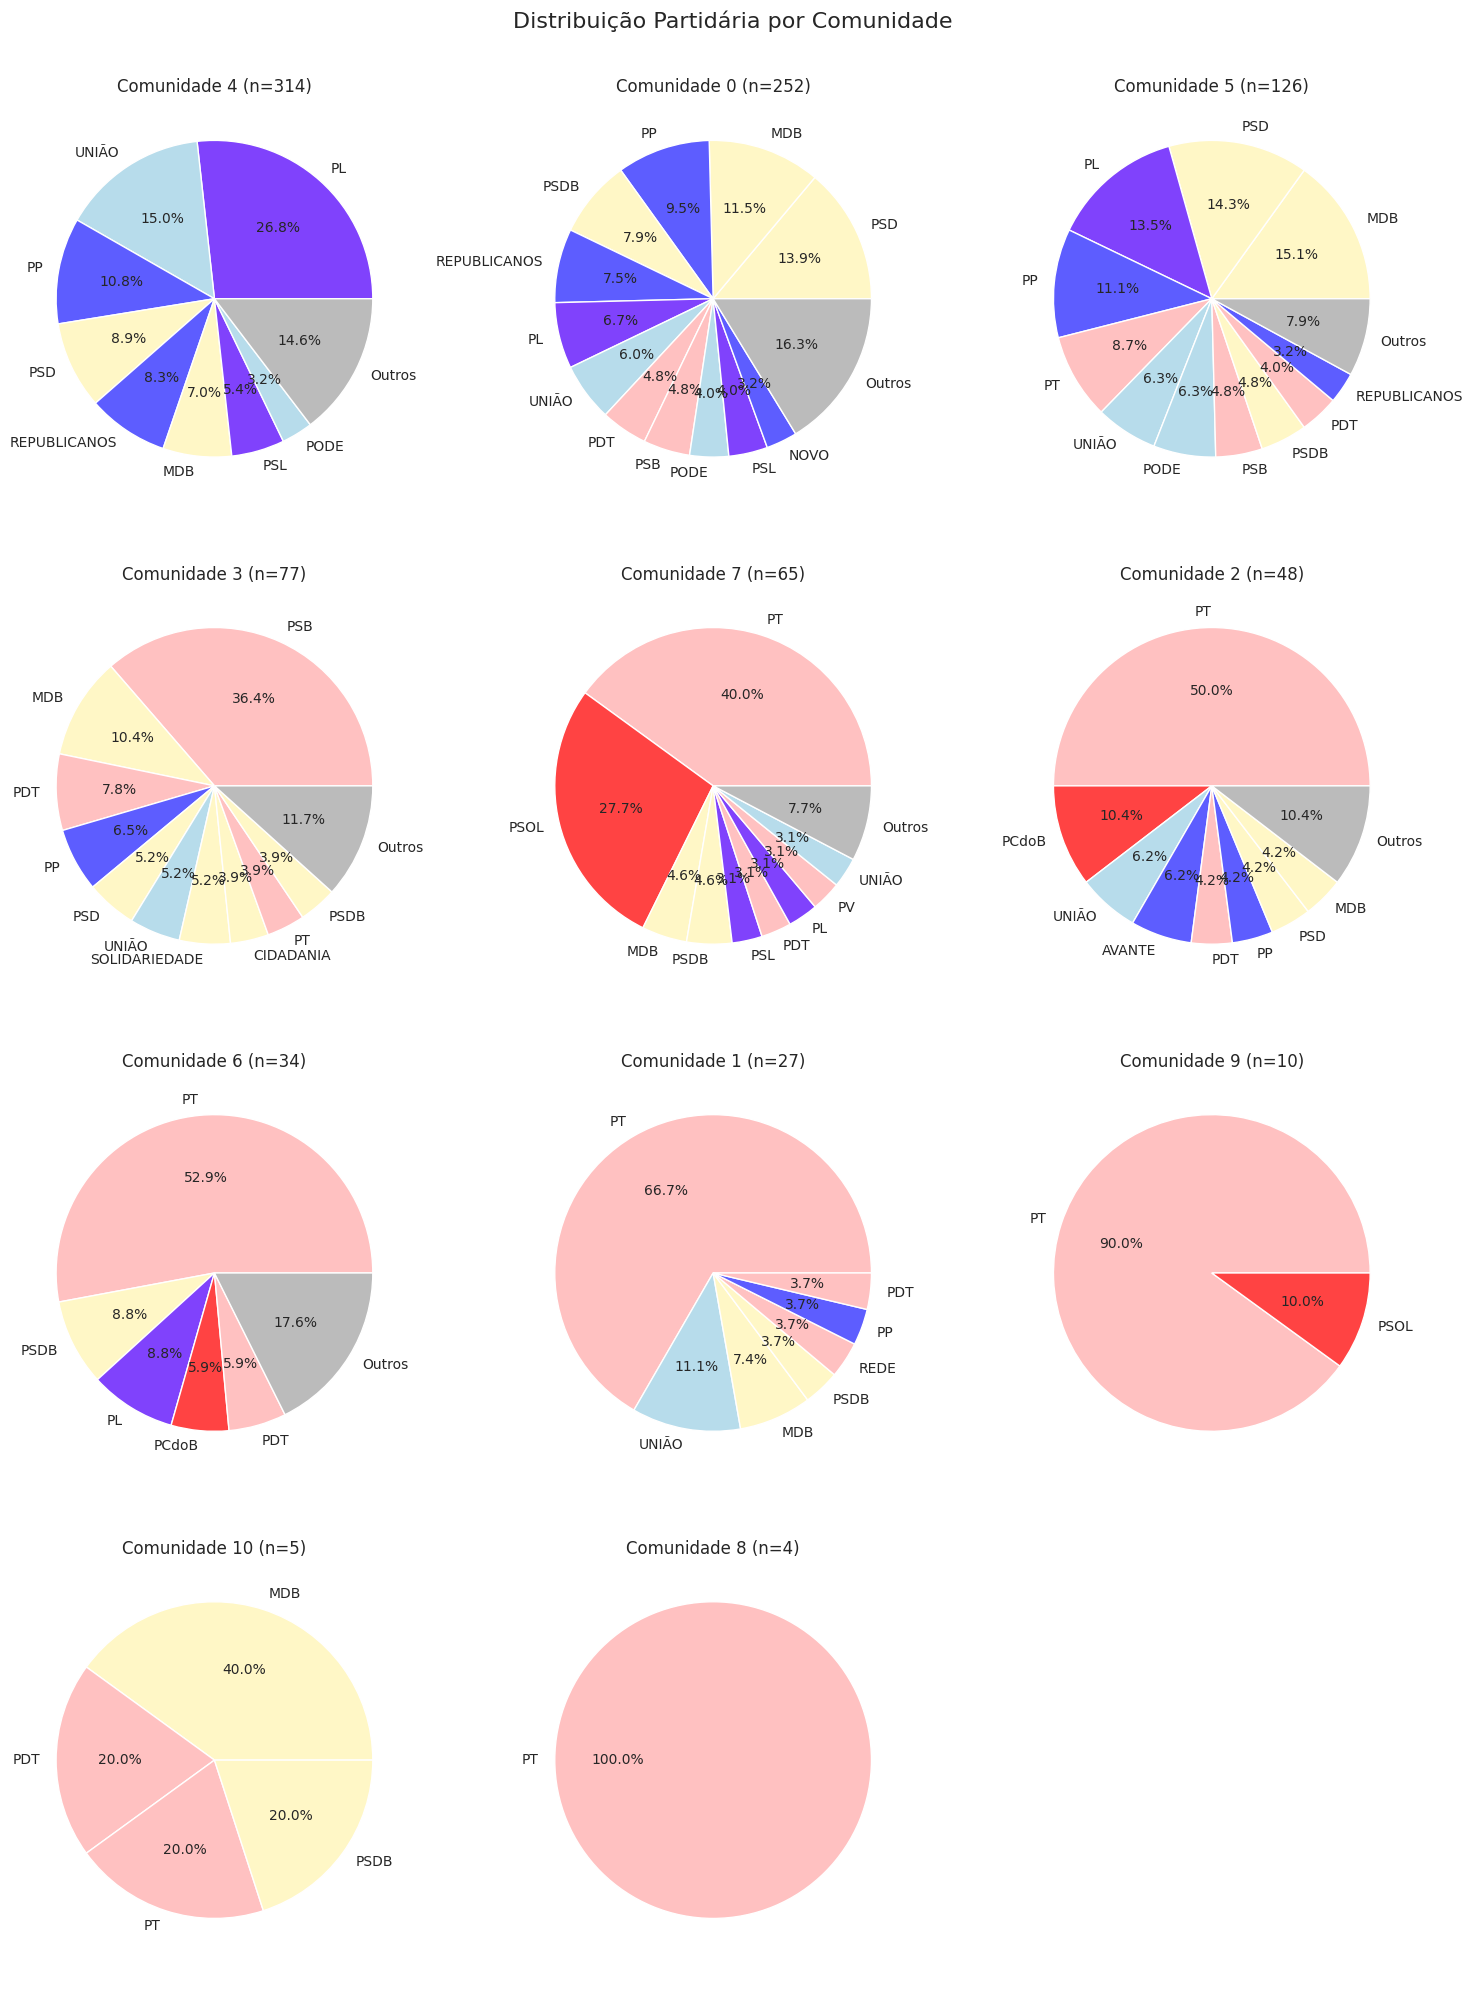

In [3]:
collab_node_no_ents_df = collab_node_df[collab_node_df['type'].ne('Orgao')]

ideol_by_party = (
    collab_node_no_ents_df[['cod_partido', 'ideol_partido']]
        .drop_duplicates()
        .set_index('cod_partido', drop=True)['ideol_partido']
        .to_dict()
)
comm_df = collab_node_no_ents_df.groupby('leiden_mod').agg(
    size=('leiden_mod', 'size'),
    author_type=('type', lambda x: x.value_counts().to_dict()),
    party=('cod_partido', lambda x: x.value_counts().to_dict()),
    ideology=('ideol_partido', lambda x: x.value_counts().to_dict()),
    region=('regiao', lambda x: x.value_counts().to_dict()),
    state=('uf', lambda x: x.value_counts().to_dict()),
).sort_values('size', ascending=False)[['size', 'party', 'ideology']]


ideology_colors = {
    'left': "#FF4343",
    'centre-left': "#FFC1C1",
    'centre': "#FFF7C6",
    'centre-right': "#B7DCEB",
    'right': "#5D5DFF",
    'far-right': "#8042FC"
}

# Create a figure with subplots for each community
n_communities = len(comm_df)
n_cols = 3  # Number of columns in subplot grid
n_rows = (n_communities + n_cols - 1) // n_cols  # Calculate needed rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten() if n_communities > 1 else [axes]

fig.suptitle('Distribuição Partidária por Comunidade', fontsize=16, y=0.995)

for idx, (comm_id, row) in enumerate(comm_df.iterrows()):
    party_dict = row['party']

    # Group parties that represent less than 5% of the community into "Outros"
    total_members = row['size'] or 1
    major_parties = []
    others_total = 0

    for party, count in sorted(party_dict.items(), key=lambda x: x[1], reverse=True):
        share = count / total_members
        if share < 0.03:
            others_total += count
        else:
            major_parties.append((party, count))

    if not major_parties and others_total:
        major_parties.append(('Outros', others_total))
        others_total = 0

    labels = [party for party, _ in major_parties]
    sizes = [count for _, count in major_parties]
    colors = [
        ideology_colors.get(ideol_by_party.get(party, ''), '#CCCCCC')
        if party != 'Outros' else '#BBBBBB'
        for party in labels
    ]

    if others_total > 0:
        labels.append('Outros')
        sizes.append(others_total)
        colors.append('#BBBBBB')

    ax = axes[idx]
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
    ax.set_title(f'Comunidade {comm_id} (n={row["size"]})')

# Hide any unused subplots
for idx in range(n_communities, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### 4.2.2. Cálculo do índice de concentração

Vamos agora calcular a concentração de cada partido. Usaremos para isso o índice de Gini para valores discretos, com o coeificente final equivalendo a 1.0 se o partido está totalmente concentrado em uma única comunidade e próximo a 0.0 se cada membro está numa comunidade diferente.

**Cálculo**

Dado um partido com $N$ membros, distribuídos em uma ou mais de $K$ comunidades totais, sejam $s_1, s_2, \ldots, s_K$ o número de membros desse partido em cada comunidade, e portanto $\sum_{i=1}^{K}s_i = N$.

Calculamos então o índice Gini $G$ pela fórmula:

$$G = \frac{1}{2K}\sum_{i=1}^{K}\sum_{j=1}^{K}|s_i-s_j|$$

Normalizamos então, para que 1.0 corresponda a concentração total:

$$\widetilde{G} = \frac{G}{1 - \frac{1}{K}}$$

In [4]:
pivot_df = collab_node_no_ents_df.pivot_table(
    columns='leiden_mod',
    index='cod_partido',
    aggfunc='size',
    fill_value=0
)
pivot_df

leiden_mod,0,1,2,3,4,5,6,7,8,9,10
cod_partido,,,,,,,,,,,
AVANTE,3,0,3,0,4,0,1,0,0,0,0
CIDADANIA,4,0,0,3,0,0,0,0,0,0,0
DEM,4,0,0,0,4,2,0,0,0,0,0
MDB,29,2,2,8,22,19,0,3,0,0,2
NOVO,8,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
REPUBLICANOS,19,0,0,1,26,4,1,0,0,0,0
SOLIDARIEDADE,5,0,1,4,0,0,0,0,0,0,0
Sem Partido,0,0,0,0,0,1,0,0,0,0,0


Vejamos como os maiores partidos se comportam. Quanto maior a área abaixo da diagonal, mais coeso o partido é (maior o Gini).

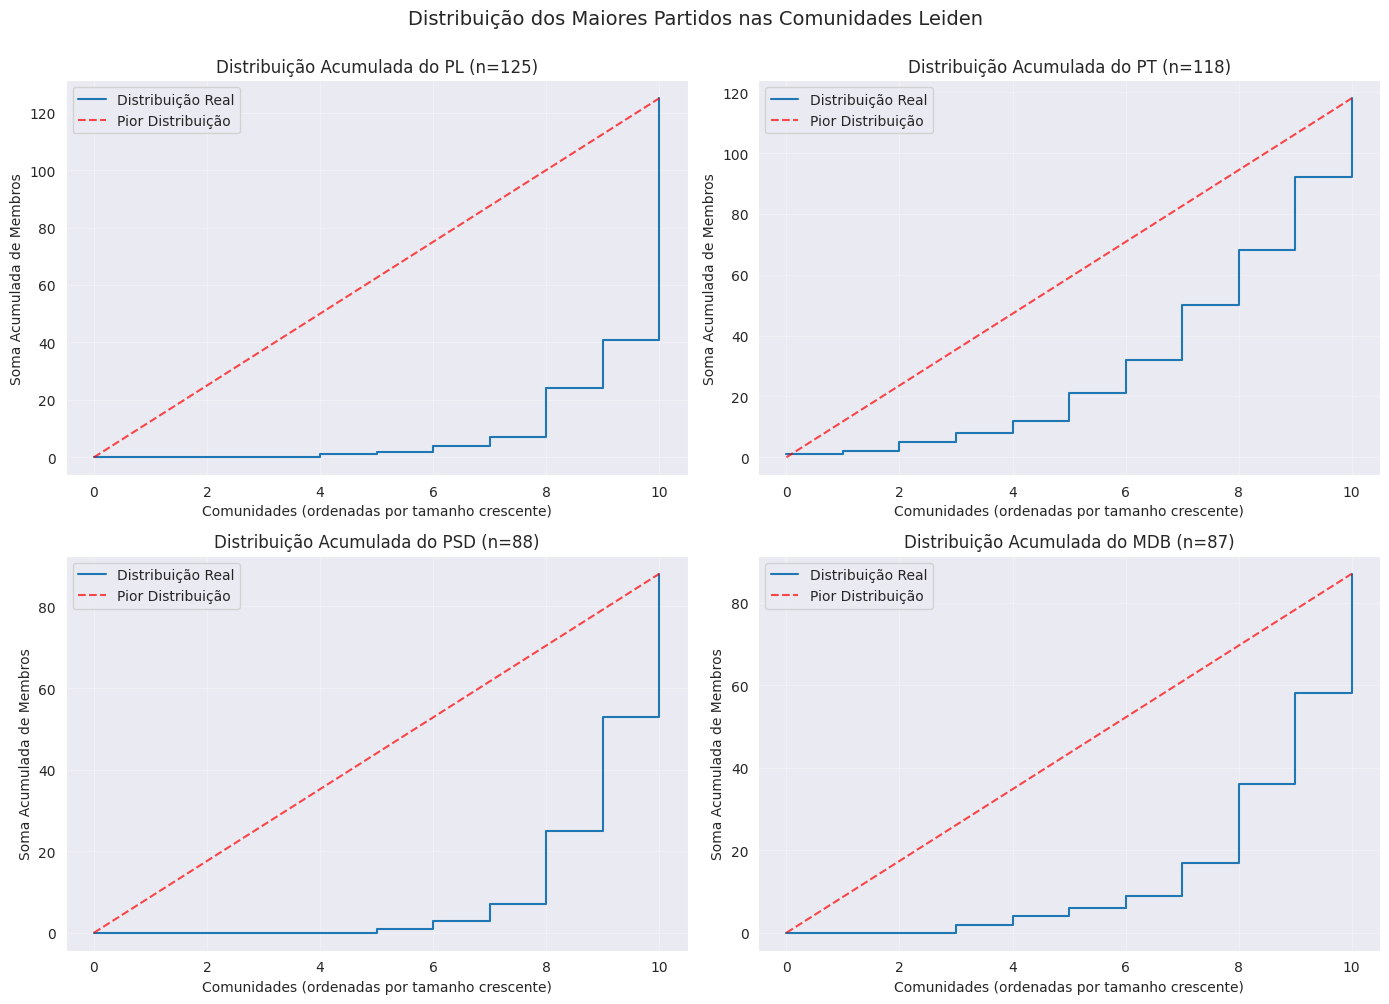

In [5]:
biggest_parties = collab_node_no_ents_df.value_counts('cod_partido', ascending=False)[:4]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (party_name, party_count) in enumerate(biggest_parties.items()):
    ax = axes[idx]
    
    party_sorted = pivot_df.loc[party_name, :].sort_values()
    party_cumsum = party_sorted.cumsum()
    
    ax.step(range(len(party_cumsum)), party_cumsum.values, where='post', label='Distribuição Real')
    ax.plot([0, len(party_cumsum) - 1], [0, party_cumsum.iloc[-1]], 
            linestyle='--', color='red', alpha=0.7, label='Pior Distribuição')
    ax.set_xlabel('Comunidades (ordenadas por tamanho crescente)')
    ax.set_ylabel('Soma Acumulada de Membros')
    ax.set_title(f'Distribuição Acumulada do {party_name} (n={party_count})')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Distribuição dos Maiores Partidos nas Comunidades Leiden', fontsize=14, y=1.0)
plt.tight_layout()
plt.show()

Vemos que o PL aparenta ser mais coeso em termos de sua distribuição em comunidades, enquanto o PT é mais difuso.

Vamos agora calcular os índices para todos os partidos.

In [6]:
pivot_normalized_df = pivot_df.div(pivot_df.sum(axis=1), axis=0)
pivot_normalized_df

leiden_mod,0,1,2,3,4,5,6,7,8,9,10
cod_partido,,,,,,,,,,,
AVANTE,0.272727,0.000000,0.272727,0.000000,0.363636,0.000000,0.090909,0.000000,0.0,0.0,0.000000
CIDADANIA,0.571429,0.000000,0.000000,0.428571,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
DEM,0.400000,0.000000,0.000000,0.000000,0.400000,0.200000,0.000000,0.000000,0.0,0.0,0.000000
MDB,0.333333,0.022989,0.022989,0.091954,0.252874,0.218391,0.000000,0.034483,0.0,0.0,0.022989
NOVO,0.800000,0.000000,0.000000,0.000000,0.100000,0.100000,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
REPUBLICANOS,0.372549,0.000000,0.000000,0.019608,0.509804,0.078431,0.019608,0.000000,0.0,0.0,0.000000
SOLIDARIEDADE,0.500000,0.000000,0.100000,0.400000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
Sem Partido,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.000000


In [7]:
gini_df = pd.DataFrame(pivot_normalized_df.apply(get_gini, axis=1), columns=["gini"])
gini_df

,gini
cod_partido,
AVANTE,0.782
CIDADANIA,0.914
DEM,0.840
MDB,0.697
NOVO,0.940
...,...
REPUBLICANOS,0.867
SOLIDARIEDADE,0.880
Sem Partido,1.000


Temos que levar em conta o tamanho dos partidos, entretanto.

In [8]:
gini_df = gini_df.join(collab_node_df.value_counts('cod_partido'))
gini_df.sort_values('gini', ascending=False)

,gini,count
cod_partido,,
PPS,1.000,1
PHS,1.000,2
UDN,1.000,2
Sem Partido,1.000,1
PSOL,0.989,19
...,...,...
PV,0.767,6
MDB,0.697,87
PSDB,0.688,43


Por óbvio, partidos com menos membros tendem a se fragmentar menos. Vamos considerar apenas aqueles com 10 membros ou mais:

In [9]:
gini_df[gini_df['count'].ge(10)].sort_values('gini', ascending=False)

,gini,count
cod_partido,,
PSOL,0.989,19
NOVO,0.940,10
PR,0.909,11
SOLIDARIEDADE,0.880,10
PRB,0.880,10
PSB,0.875,48
PL,0.874,125
REPUBLICANOS,0.867,51
DEM,0.840,10


## 4.3. Visualização do progresso de proposições



In [10]:
node_df = pd.read_pickle(ACCESS_DIR / "node_consolidated_df.pkl")
edge_df = pd.read_pickle(ACCESS_DIR / "edge_consolidated_df.pkl")

In [11]:
node_df.head()

,name,label,partido,type,score,bigtype,billtype,cod_partido,uf,ideol_partido,score_label,regiao
0,CP:2187087,PL 5029/2019,,Proposicao,1.00,bill,PL,not_applicable,,none,floor-2,none
1,CP:2190408,PL 2/2019,,Proposicao,0.25,bill,PL,not_applicable,,none,committee-1,none
2,CP:2190417,PL 10/2019,,Proposicao,0.25,bill,PL,not_applicable,,none,committee-1,none
3,CP:2190423,PL 15/2019,,Proposicao,0.00,bill,PL,not_applicable,,none,filed,none
4,CP:2190450,PL 21/2019,,Proposicao,0.25,bill,PL,not_applicable,,none,committee-1,none


In [12]:
edge_df.head()

,from,to,weight
0,CD:160655,CP:538196,1.000001
1,CD:141488,CP:559138,1.000001
2,CD:73584,CP:593065,1.000001
3,CD:160518,CP:601739,0.250001
4,SS:4811,CP:614512,1.000001


In [13]:
bill_df = edge_df.join(
    node_df.set_index('name')[['label', 'type']],
    on="from",
).join(
    node_df.set_index('name')[['label', 'score_label']],
    on="to",
    lsuffix="_auth",
    rsuffix="_bill"
)[['label_auth', 'type', 'label_bill', 'score_label']].reset_index(drop=True)
bill_df['billtype'] = bill_df['label_bill'].apply(lambda s: s.split()[0])
bill_df

,label_auth,type,label_bill,score_label,billtype
0,RICARDO IZAR JUNIOR,Deputado,PL 6610/2019,floor-2,PL
1,LUIZ PAULO TEIXEIRA FERREIRA,Deputado,PL 6606/2019,floor-2,PL
2,ANTONIO CARLOS DE MENDES THAME,Deputado,PL 4476/2020,floor-2,PL
3,WELITON FERNANDES PRADO,Deputado,PL 6054/2019,committee-1,PL
4,LAÉRCIO JOSÉ DE OLIVEIRA,Senador,PL 4157/2019,floor-2,PL
...,...,...,...,...,...
49201,DAMARES REGINA ALVES,Senador,PEC 36/2024,committee-1,PEC
49202,FRANCISCO PLÍNIO VALÉRIO TOMAZ,Senador,PEC 36/2024,committee-1,PEC
49203,ANTONIO HAMILTON MARTINS MOURÃO,Senador,PEC 36/2024,committee-1,PEC
49204,MARCOS CESAR PONTES,Senador,PEC 36/2024,committee-1,PEC


### 4.3.1. Proposições do Poder Executivo

In [14]:
pres_bill_df = bill_df[bill_df['label_auth'].eq("PODER EXECUTIVO")]

In [15]:
pres_bill_df

,label_auth,type,label_bill,score_label,billtype
172,PODER EXECUTIVO,Orgao,PL 1645/2019,committee-1,PL
243,PODER EXECUTIVO,Orgao,PL 2401/2019,committee-1,PL
320,PODER EXECUTIVO,Orgao,PL 3267/2019,floor-2,PL
324,PODER EXECUTIVO,Orgao,PLP 149/2019,committee-2,PLP
355,PODER EXECUTIVO,Orgao,MPV 886/2019,floor-1,MPV
...,...,...,...,...,...
44724,PODER EXECUTIVO,Orgao,MPV 1282/2024,committee-1,MPV
44729,PODER EXECUTIVO,Orgao,MPV 1283/2024,committee-1,MPV
44730,PODER EXECUTIVO,Orgao,MPV 1284/2024,floor-1,MPV
44731,PODER EXECUTIVO,Orgao,MPV 1285/2024,filed,MPV


In [16]:
import plotly.graph_objects as go
from plotly.colors import qualitative as qualitative_colors
import itertools

# IDs internos dos estágios
stage_order = ["filed", "committee-1", "floor-1", "committee-2", "floor-2"]
stage_to_idx = {stage: idx for idx, stage in enumerate(stage_order)}

# Mapeamento para nomes exibidos (estágios)
stage_display = {
    "filed": "Protocolada",
    "committee-1": "Comissão da Câmara",
    "floor-1": "Aprovada na Câmara",
    "committee-2": "Comissão do Senado",
    "floor-2": "Aprovada no Senado",
}

# Personalização dos rótulos de saída (final)
# - FINAL_SUFFIX define o sufixo padrão a ser anexado ao nome do estágio
# - FINAL_DISPLAY permite sobrescrever por estágio específico
FINAL_SUFFIX = " (final)"
FINAL_DISPLAY = {
    "filed": "Só protocolada",
    "committee-1": "Só comissão da Câmara",
    "floor-1": "Só aprovada na Câmara",
    "committee-2": "Só comissão do Senado",
    "floor-2": "Enviada para sanção/promulgação",
}

# Separador de linha para rótulos do Plotly
LINE_BREAK = "<br>"

flow_source_df = pres_bill_df.dropna(subset=["billtype", "score_label"]).copy()
flow_source_df = flow_source_df[flow_source_df["score_label"].isin(stage_order)].copy()
flow_source_df["stage_index"] = flow_source_df["score_label"].map(stage_to_idx)

if flow_source_df.empty:
    print("Nenhuma proposição presidencial com os estágios informados.")
else:
    final_stage_counts = (
        flow_source_df.groupby(["billtype", "stage_index"], as_index=False)
        .size()
        .rename(columns={"size": "count"})
    )

    stage_counts_pivot = (
        final_stage_counts.pivot(index="billtype", columns="stage_index", values="count")
        .fillna(0)
        .astype(int)
        .reindex(columns=range(len(stage_order)), fill_value=0)
    )

    if stage_counts_pivot.empty:
        print("Nenhuma proposição presidencial com os estágios informados.")
    else:
        billtypes = stage_counts_pivot.index.tolist()
        billtypes.sort(key=lambda bt: stage_counts_pivot.loc[bt].sum(), reverse=True)

        total_per_type = stage_counts_pivot.sum(axis=1).astype(int)
        final_counts_by_stage = stage_counts_pivot.sum(axis=0).astype(int)
        survivors_by_stage = final_counts_by_stage.iloc[::-1].cumsum().iloc[::-1].astype(int)

        stage_reached_counts = {
            stage_order[idx]: int(survivors_by_stage.iloc[idx])
            for idx in range(len(stage_order))
        }
        final_counts_map = {
            stage_order[idx]: int(final_counts_by_stage.iloc[idx])
            for idx in range(len(stage_order))
        }

        node_labels_internal = []  # manter rótulos internos para o grafo
        node_index = {}

        def ensure_node(label: str):
            if label not in node_index:
                node_index[label] = len(node_labels_internal)
                node_labels_internal.append(label)
            return node_index[label]

        # Tipo das proposições (origem) -> estágio 'filed'
        for billtype in billtypes:
            ensure_node(billtype)

        # Nós dos estágios agregados
        for stage in stage_order:
            ensure_node(stage)

        # Nós finais ("saídas") por estágio
        for stage in stage_order:
            ensure_node(f"{stage} (final)")

        sources = []
        targets = []
        values = []
        link_custom = []

        def pretty_stage(internal: str) -> str:
            # Converte identificador interno para nome exibido
            return stage_display.get(internal, internal)

        def pretty_final(internal_stage: str) -> str:
            # Nome exibido para nós finais; permite override por estágio
            return FINAL_DISPLAY.get(internal_stage, f"{pretty_stage(internal_stage)}{FINAL_SUFFIX}")

        def pretty_label(label: str) -> str:
            if label.endswith("(final)"):
                base = label[:-8].strip()
                return pretty_final(base)
            elif label in stage_order:
                return pretty_stage(label)
            else:
                return label  # billtype

        def label_with_count(label: str) -> str:
            if label.endswith("(final)"):
                base = label[:-8].strip()
                count = final_counts_map.get(base, 0)
                return f"{pretty_final(base)}{LINE_BREAK}(n={count})"
            if label in stage_order:
                count = stage_reached_counts.get(label, 0)
                return f"{pretty_stage(label)}{LINE_BREAK}(n={count})"
            if label in total_per_type.index:
                count = int(total_per_type.loc[label])
                return f"{label}{LINE_BREAK}(n={count})"
            return pretty_label(label)

        def add_link(src_label: str, tgt_label: str, value: int):
            value = int(value)
            if value <= 0:
                return
            sources.append(node_index[src_label])
            targets.append(node_index[tgt_label])
            values.append(value)
            link_custom.append(f"{pretty_label(src_label)} → {pretty_label(tgt_label)}: {value}")

        # Fluxo inicial: cada tipo alimenta 'filed'
        filed_stage = stage_order[0]
        for billtype in billtypes:
            count = int(total_per_type.loc[billtype])
            add_link(billtype, filed_stage, count)

        # Para cada estágio: saída final + sobreviventes para o próximo
        for idx, stage in enumerate(stage_order):
            final_here = int(final_counts_by_stage.iloc[idx])
            add_link(stage, f"{stage} (final)", final_here)
            if idx < len(stage_order) - 1:
                survivors_next = int(survivors_by_stage.iloc[idx + 1])
                next_stage = stage_order[idx + 1]
                add_link(stage, next_stage, survivors_next)

        # Cores dos tipos
        palette_cycle = itertools.cycle(qualitative_colors.Plotly)
        type_color = {billtype: next(palette_cycle) for billtype in billtypes}

        # Paleta de estágios
        stage_palette = ["#4C78A8", "#F58518", "#E45756", "#72B7B2", "#54A24B"]
        stage_color_map = {stage: stage_palette[idx % len(stage_palette)] for idx, stage in enumerate(stage_order)}

        def base_of(label: str) -> str:
            if label.endswith("(final)"):
                return label[:-8].strip()
            return label

        node_colors = []
        for label in node_labels_internal:
            base = base_of(label)
            if base in type_color:
                node_colors.append(type_color[base])
            elif base in stage_color_map and not label.endswith("(final)"):
                node_colors.append(stage_color_map[base])
            elif label.endswith("(final)"):
                node_colors.append("#9e9e9e")
            else:
                node_colors.append("#BBBBBB")

        # Rótulos exibidos (mapeados)
        display_labels = [label_with_count(lbl) for lbl in node_labels_internal]

        sankey_fig = go.Figure(
            data=[
                go.Sankey(
                    node=dict(
                        label=display_labels,
                        pad=18,
                        thickness=16,
                        color=node_colors,
                    ),
                    link=dict(
                        source=sources,
                        target=targets,
                        value=values,
                        hovertemplate="%{customdata}<extra></extra>",
                        customdata=link_custom,
                    ),
                )
            ]
        )

        sankey_fig.update_layout(
            title_text="Fluxo agregado de proposições presidenciais pelos estágios de tramitação",
            font=dict(size=12),
            margin=dict(l=40, r=40, t=50, b=20),
        )
        sankey_fig.show()

In [17]:
sankey_fig.update_layout(
    width=1200, height=700, font=dict(size=14),
)
sankey_fig.write_image(OUT_DIR / "sankey_presidencia.png", scale=3)

### 4.3.2. Câmara dos Deputados

In [18]:
house_bill_df = bill_df[bill_df['type'].eq("Deputado")]

In [19]:
import plotly.graph_objects as go
from plotly.colors import qualitative as qualitative_colors
import itertools

# IDs internos dos estágios
stage_order = ["filed", "committee-1", "floor-1", "committee-2", "floor-2"]
stage_to_idx = {stage: idx for idx, stage in enumerate(stage_order)}

# Mapeamento para nomes exibidos (estágios)
stage_display = {
    "filed": "Protocolada",
    "committee-1": "Comissão da Câmara",
    "floor-1": "Aprovada na Câmara",
    "committee-2": "Comissão do Senado",
    "floor-2": "Aprovada no Senado",
}

# Personalização dos rótulos de saída (final)
# - FINAL_SUFFIX define o sufixo padrão a ser anexado ao nome do estágio
# - FINAL_DISPLAY permite sobrescrever por estágio específico
FINAL_SUFFIX = " (final)"
FINAL_DISPLAY = {
    "filed": "Só protocolada",
    "committee-1": "Só comissão da Câmara",
    "floor-1": "Só aprovada na Câmara",
    "committee-2": "Só comissão do Senado",
    "floor-2": "Enviada para sanção/promulgação",
}

# Separador de linha para rótulos do Plotly
LINE_BREAK = "<br>"

flow_source_df = house_bill_df.dropna(subset=["billtype", "score_label"]).copy()
flow_source_df = flow_source_df[flow_source_df["score_label"].isin(stage_order)].copy()
flow_source_df["stage_index"] = flow_source_df["score_label"].map(stage_to_idx)

if flow_source_df.empty:
    print("Nenhuma proposição da Câmara com os estágios informados.")
else:
    final_stage_counts = (
        flow_source_df.groupby(["billtype", "stage_index"], as_index=False)
        .size()
        .rename(columns={"size": "count"})
    )

    stage_counts_pivot = (
        final_stage_counts.pivot(index="billtype", columns="stage_index", values="count")
        .fillna(0)
        .astype(int)
        .reindex(columns=range(len(stage_order)), fill_value=0)
    )

    if stage_counts_pivot.empty:
        print("Nenhuma proposição da Câmara com os estágios informados.")
    else:
        billtypes = stage_counts_pivot.index.tolist()
        billtypes.sort(key=lambda bt: stage_counts_pivot.loc[bt].sum(), reverse=True)

        total_per_type = stage_counts_pivot.sum(axis=1).astype(int)
        final_counts_by_stage = stage_counts_pivot.sum(axis=0).astype(int)
        survivors_by_stage = final_counts_by_stage.iloc[::-1].cumsum().iloc[::-1].astype(int)

        stage_reached_counts = {
            stage_order[idx]: int(survivors_by_stage.iloc[idx])
            for idx in range(len(stage_order))
        }
        final_counts_map = {
            stage_order[idx]: int(final_counts_by_stage.iloc[idx])
            for idx in range(len(stage_order))
        }

        node_labels_internal = []  # manter rótulos internos para o grafo
        node_index = {}

        def ensure_node(label: str):
            if label not in node_index:
                node_index[label] = len(node_labels_internal)
                node_labels_internal.append(label)
            return node_index[label]

        # Tipo das proposições (origem) -> estágio 'filed'
        for billtype in billtypes:
            ensure_node(billtype)

        # Nós dos estágios agregados
        for stage in stage_order:
            ensure_node(stage)

        # Nós finais ("saídas") por estágio
        for stage in stage_order:
            ensure_node(f"{stage} (final)")

        sources = []
        targets = []
        values = []
        link_custom = []

        def pretty_stage(internal: str) -> str:
            # Converte identificador interno para nome exibido
            return stage_display.get(internal, internal)

        def pretty_final(internal_stage: str) -> str:
            # Nome exibido para nós finais; permite override por estágio
            return FINAL_DISPLAY.get(internal_stage, f"{pretty_stage(internal_stage)}{FINAL_SUFFIX}")

        def pretty_label(label: str) -> str:
            if label.endswith("(final)"):
                base = label[:-8].strip()
                return pretty_final(base)
            elif label in stage_order:
                return pretty_stage(label)
            else:
                return label  # billtype

        def label_with_count(label: str) -> str:
            if label.endswith("(final)"):
                base = label[:-8].strip()
                count = final_counts_map.get(base, 0)
                return f"{pretty_final(base)}{LINE_BREAK}(n={count})"
            if label in stage_order:
                count = stage_reached_counts.get(label, 0)
                return f"{pretty_stage(label)}{LINE_BREAK}(n={count})"
            if label in total_per_type.index:
                count = int(total_per_type.loc[label])
                return f"{label}{LINE_BREAK}(n={count})"
            return pretty_label(label)

        def add_link(src_label: str, tgt_label: str, value: int):
            value = int(value)
            if value <= 0:
                return
            sources.append(node_index[src_label])
            targets.append(node_index[tgt_label])
            values.append(value)
            link_custom.append(f"{pretty_label(src_label)} → {pretty_label(tgt_label)}: {value}")

        # Fluxo inicial: cada tipo alimenta 'filed'
        filed_stage = stage_order[0]
        for billtype in billtypes:
            count = int(total_per_type.loc[billtype])
            add_link(billtype, filed_stage, count)

        # Para cada estágio: saída final + sobreviventes para o próximo
        for idx, stage in enumerate(stage_order):
            final_here = int(final_counts_by_stage.iloc[idx])
            add_link(stage, f"{stage} (final)", final_here)
            if idx < len(stage_order) - 1:
                survivors_next = int(survivors_by_stage.iloc[idx + 1])
                next_stage = stage_order[idx + 1]
                add_link(stage, next_stage, survivors_next)

        # Cores dos tipos
        palette_cycle = itertools.cycle(qualitative_colors.Plotly)
        type_color = {billtype: next(palette_cycle) for billtype in billtypes}

        # Paleta de estágios
        stage_palette = ["#4C78A8", "#F58518", "#E45756", "#72B7B2", "#54A24B"]
        stage_color_map = {stage: stage_palette[idx % len(stage_palette)] for idx, stage in enumerate(stage_order)}

        def base_of(label: str) -> str:
            if label.endswith("(final)"):
                return label[:-8].strip()
            return label

        node_colors = []
        for label in node_labels_internal:
            base = base_of(label)
            if base in type_color:
                node_colors.append(type_color[base])
            elif base in stage_color_map and not label.endswith("(final)"):
                node_colors.append(stage_color_map[base])
            elif label.endswith("(final)"):
                node_colors.append("#9e9e9e")
            else:
                node_colors.append("#BBBBBB")

        # Rótulos exibidos (mapeados)
        display_labels = [label_with_count(lbl) for lbl in node_labels_internal]

        sankey_fig = go.Figure(
            data=[
                go.Sankey(
                    node=dict(
                        label=display_labels,
                        pad=18,
                        thickness=16,
                        color=node_colors,
                    ),
                    link=dict(
                        source=sources,
                        target=targets,
                        value=values,
                        hovertemplate="%{customdata}<extra></extra>",
                        customdata=link_custom,
                    ),
                )
            ]
        )

        sankey_fig.update_layout(
            title_text="Fluxo agregado de proposições de deputados pelos estágios de tramitação",
            font=dict(size=12),
            margin=dict(l=40, r=40, t=50, b=20),
        )
        sankey_fig.show()

In [20]:
sankey_fig.update_layout(
    width=1200, height=700, font=dict(size=14),
)
sankey_fig.write_image(OUT_DIR / "sankey_camara.png", scale=3)

### 4.3.3. Senado Federal

In [21]:
senate_bill_df = bill_df[bill_df['type'].eq("Senador")]

In [22]:

import plotly.graph_objects as go
from plotly.colors import qualitative as qualitative_colors
import itertools

# IDs internos dos estágios
stage_order = ["filed", "committee-1", "floor-1", "committee-2", "floor-2"]
stage_to_idx = {stage: idx for idx, stage in enumerate(stage_order)}

# Mapeamento para nomes exibidos (estágios)
stage_display = {
    "filed": "Protocolada",
    "committee-1": "Comissão do Senado",
    "floor-1": "Aprovada no Senado",
    "committee-2": "Comissão da Câmara",
    "floor-2": "Aprovada na Câmara",
}

# Personalização dos rótulos de saída (final)
# - FINAL_SUFFIX define o sufixo padrão a ser anexado ao nome do estágio
# - FINAL_DISPLAY permite sobrescrever por estágio específico
FINAL_SUFFIX = " (final)"
FINAL_DISPLAY = {
    "filed": "Só protocolada",
    "committee-1": "Só comissão do Senado",
    "floor-1": "Só aprovada no Senado",
    "committee-2": "Só comissão da Câmara",
    "floor-2": "Enviada para sanção/promulgação",
}

# Separador de linha para rótulos do Plotly
LINE_BREAK = "<br>"

flow_source_df = senate_bill_df.dropna(subset=["billtype", "score_label"]).copy()
flow_source_df = flow_source_df[flow_source_df["score_label"].isin(stage_order)].copy()
flow_source_df["stage_index"] = flow_source_df["score_label"].map(stage_to_idx)

if flow_source_df.empty:
    print("Nenhuma proposição do Senado com os estágios informados.")
else:
    final_stage_counts = (
        flow_source_df.groupby(["billtype", "stage_index"], as_index=False)
        .size()
        .rename(columns={"size": "count"})
    )

    stage_counts_pivot = (
        final_stage_counts.pivot(index="billtype", columns="stage_index", values="count")
        .fillna(0)
        .astype(int)
        .reindex(columns=range(len(stage_order)), fill_value=0)
    )

    if stage_counts_pivot.empty:
        print("Nenhuma proposição do Senado com os estágios informados.")
    else:
        billtypes = stage_counts_pivot.index.tolist()
        billtypes.sort(key=lambda bt: stage_counts_pivot.loc[bt].sum(), reverse=True)

        total_per_type = stage_counts_pivot.sum(axis=1).astype(int)
        final_counts_by_stage = stage_counts_pivot.sum(axis=0).astype(int)
        survivors_by_stage = final_counts_by_stage.iloc[::-1].cumsum().iloc[::-1].astype(int)

        stage_reached_counts = {
            stage_order[idx]: int(survivors_by_stage.iloc[idx])
            for idx in range(len(stage_order))
        }
        final_counts_map = {
            stage_order[idx]: int(final_counts_by_stage.iloc[idx])
            for idx in range(len(stage_order))
        }

        node_labels_internal = []  # manter rótulos internos para o grafo
        node_index = {}

        def ensure_node(label: str):
            if label not in node_index:
                node_index[label] = len(node_labels_internal)
                node_labels_internal.append(label)
            return node_index[label]

        # Tipo das proposições (origem) -> estágio 'filed'
        for billtype in billtypes:
            ensure_node(billtype)

        # Nós dos estágios agregados
        for stage in stage_order:
            ensure_node(stage)

        # Nós finais ("saídas") por estágio
        for stage in stage_order:
            ensure_node(f"{stage} (final)")

        sources = []
        targets = []
        values = []
        link_custom = []

        def pretty_stage(internal: str) -> str:
            # Converte identificador interno para nome exibido
            return stage_display.get(internal, internal)

        def pretty_final(internal_stage: str) -> str:
            # Nome exibido para nós finais; permite override por estágio
            return FINAL_DISPLAY.get(internal_stage, f"{pretty_stage(internal_stage)}{FINAL_SUFFIX}")

        def pretty_label(label: str) -> str:
            if label.endswith("(final)"):
                base = label[:-8].strip()
                return pretty_final(base)
            elif label in stage_order:
                return pretty_stage(label)
            else:
                return label  # billtype

        def label_with_count(label: str) -> str:
            if label.endswith("(final)"):
                base = label[:-8].strip()
                count = final_counts_map.get(base, 0)
                return f"{pretty_final(base)}{LINE_BREAK}(n={count})"
            if label in stage_order:
                count = stage_reached_counts.get(label, 0)
                return f"{pretty_stage(label)}{LINE_BREAK}(n={count})"
            if label in total_per_type.index:
                count = int(total_per_type.loc[label])
                return f"{label}{LINE_BREAK}(n={count})"
            return pretty_label(label)

        def add_link(src_label: str, tgt_label: str, value: int):
            value = int(value)
            if value <= 0:
                return
            sources.append(node_index[src_label])
            targets.append(node_index[tgt_label])
            values.append(value)
            link_custom.append(f"{pretty_label(src_label)} → {pretty_label(tgt_label)}: {value}")

        # Fluxo inicial: cada tipo alimenta 'filed'
        filed_stage = stage_order[0]
        for billtype in billtypes:
            count = int(total_per_type.loc[billtype])
            add_link(billtype, filed_stage, count)

        # Para cada estágio: saída final + sobreviventes para o próximo
        for idx, stage in enumerate(stage_order):
            final_here = int(final_counts_by_stage.iloc[idx])
            add_link(stage, f"{stage} (final)", final_here)
            if idx < len(stage_order) - 1:
                survivors_next = int(survivors_by_stage.iloc[idx + 1])
                next_stage = stage_order[idx + 1]
                add_link(stage, next_stage, survivors_next)

        # Cores dos tipos
        palette_cycle = itertools.cycle(qualitative_colors.Plotly)
        type_color = {billtype: next(palette_cycle) for billtype in billtypes}

        # Paleta de estágios
        stage_palette = ["#4C78A8", "#F58518", "#E45756", "#72B7B2", "#54A24B"]
        stage_color_map = {stage: stage_palette[idx % len(stage_palette)] for idx, stage in enumerate(stage_order)}

        def base_of(label: str) -> str:
            if label.endswith("(final)"):
                return label[:-8].strip()
            return label

        node_colors = []
        for label in node_labels_internal:
            base = base_of(label)
            if base in type_color:
                node_colors.append(type_color[base])
            elif base in stage_color_map and not label.endswith("(final)"):
                node_colors.append(stage_color_map[base])
            elif label.endswith("(final)"):
                node_colors.append("#9e9e9e")
            else:
                node_colors.append("#BBBBBB")

        # Rótulos exibidos (mapeados)
        display_labels = [label_with_count(lbl) for lbl in node_labels_internal]

        sankey_fig = go.Figure(
            data=[
                go.Sankey(
                    node=dict(
                        label=display_labels,
                        pad=18,
                        thickness=16,
                        color=node_colors,
                    ),
                    link=dict(
                        source=sources,
                        target=targets,
                        value=values,
                        hovertemplate="%{customdata}<extra></extra>",
                        customdata=link_custom,
                    ),
                )
            ]
        )

        sankey_fig.update_layout(
            title_text="Fluxo agregado de proposições de senadores pelos estágios de tramitação",
            font=dict(size=12),
            margin=dict(l=40, r=40, t=50, b=20),
        )
        sankey_fig.show()